<a href="https://colab.research.google.com/github/Kirteeraj/Pneomina-Dectation-using-X-ray/blob/main/MobileNetV2-acc-79-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! pip install -q kaggle

In [8]:
 ! mkdir ~/.kaggle

In [9]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kirteeraj","key":"ebe4a9e772c807dd21e116caf8edb7e9"}'}

In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-21 20:52:33          14302  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           8596  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3836  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3212  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [13]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:45<00:00, 66.9MB/s]
100% 2.29G/2.29G [00:45<00:00, 53.7MB/s]


In [14]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [15]:
!pwd

/content


In [53]:
import tensorflow
import pandas as pd
import numpy as np
import os
import keras
from tensorflow.keras.applications import DenseNet169, DenseNet121, MobileNetV2
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

In [54]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [55]:
training_dir='./chest_xray/train/'
validation_dir='./chest_xray/val/'
test_dir='./chest_xray/test/'

In [56]:
test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 624 files belonging to 2 classes.


In [57]:
train_ds = image_dataset_from_directory(
    directory=training_dir,
    shuffle=True,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 5216 files belonging to 2 classes.


In [58]:
validation_ds = image_dataset_from_directory(
    directory=validation_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 16 files belonging to 2 classes.


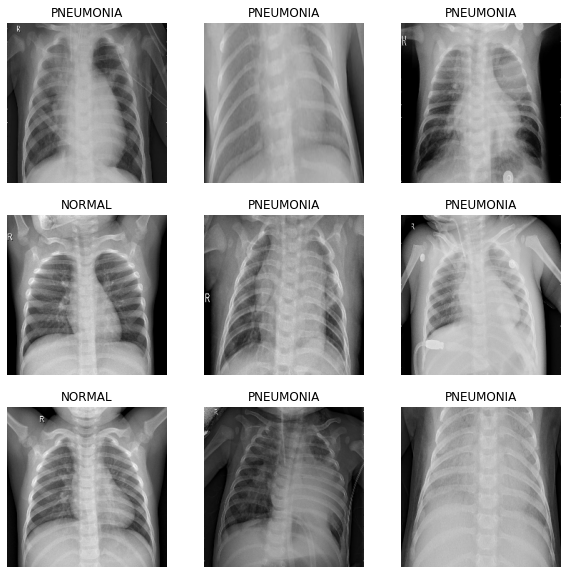

In [59]:
# data visulazation
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [60]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.05),
  # tensorflow.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tensorflow.keras.layers.experimental.preprocessing.RandomHeight(0.05),
  tensorflow.keras.layers.experimental.preprocessing.RandomWidth(0.05),
])

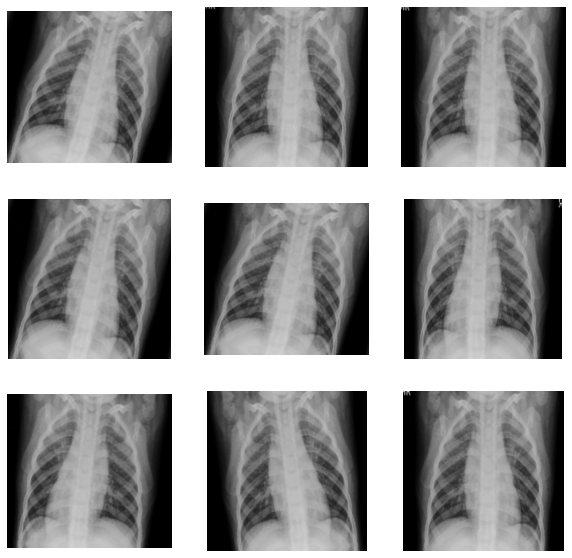

In [61]:
# data visulation for augmentation
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tensorflow.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [62]:
test_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [63]:
x=base_model.output

x= data_augmentation(x)
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.6)(x)
# x= Dense(1024,activation='relu')(x) 
x= Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.6)(x)

preds=Dense(2,activation='softmax')(x)

In [64]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [65]:
# for layer in model.layers[:-8]:
#     layer.trainable=False

# for layer in model.layers[-8:]:
#     layer.trainable=True

In [66]:
base_model.trainable = False

In [67]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [68]:
len(model.trainable_variables)

8

In [69]:
initial_epochs = 20

In [73]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.35,
                              patience=2, min_lr=0.000001)

In [74]:
history=model.fit(x=train_ds,
                           validation_data=validation_ds,
                           epochs=initial_epochs,
                           verbose=1,
                  callbacks=[reduce_lr])

Epoch 1/20
326/326 [==============================] - 34s 103ms/step - loss: 0.2783 - accuracy: 0.9260 - val_loss: 1.5404 - val_accuracy: 0.6875
Epoch 2/20
326/326 [==============================] - 34s 103ms/step - loss: 0.2834 - accuracy: 0.9266 - val_loss: 1.5798 - val_accuracy: 0.6875
Epoch 3/20
326/326 [==============================] - 34s 103ms/step - loss: 0.2787 - accuracy: 0.9275 - val_loss: 1.0567 - val_accuracy: 0.6875
Epoch 4/20
326/326 [==============================] - 33s 101ms/step - loss: 0.2762 - accuracy: 0.9275 - val_loss: 1.3287 - val_accuracy: 0.6875
Epoch 5/20
326/326 [==============================] - 34s 104ms/step - loss: 0.2796 - accuracy: 0.9304 - val_loss: 1.6145 - val_accuracy: 0.6875
Epoch 6/20
326/326 [==============================] - 35s 104ms/step - loss: 0.2727 - accuracy: 0.9300 - val_loss: 1.2634 - val_accuracy: 0.7500
Epoch 7/20
326/326 [==============================] - 34s 103ms/step - loss: 0.2459 - accuracy: 0.9425 - val_loss: 1.2240 - val_ac

In [75]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 4s 81ms/step - loss: 0.7248 - accuracy: 0.7837


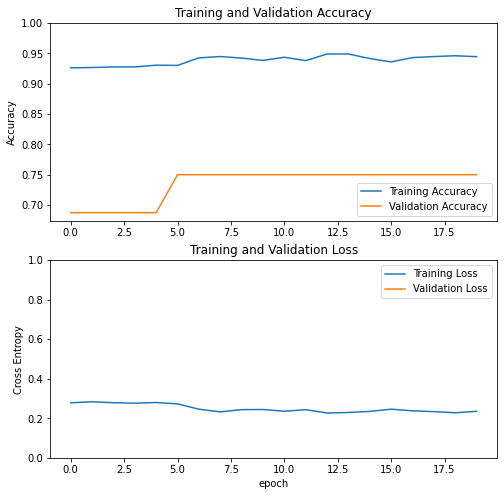

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [77]:
base_model.trainable = True

In [83]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [84]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [85]:
len(model.trainable_variables)

62

In [86]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds,
                         callbacks=[reduce_lr])

Epoch 20/40
326/326 [==============================] - 43s 115ms/step - loss: 0.3289 - accuracy: 0.9156 - val_loss: 1.4837 - val_accuracy: 0.6875
Epoch 21/40
326/326 [==============================] - 37s 110ms/step - loss: 0.2862 - accuracy: 0.9294 - val_loss: 1.4706 - val_accuracy: 0.6875
Epoch 22/40
326/326 [==============================] - 36s 110ms/step - loss: 0.2429 - accuracy: 0.9440 - val_loss: 1.4395 - val_accuracy: 0.6875
Epoch 23/40
326/326 [==============================] - 37s 112ms/step - loss: 0.2225 - accuracy: 0.9519 - val_loss: 1.1687 - val_accuracy: 0.8125
Epoch 24/40
326/326 [==============================] - 37s 112ms/step - loss: 0.2157 - accuracy: 0.9534 - val_loss: 1.0036 - val_accuracy: 0.7500
Epoch 25/40
326/326 [==============================] - 37s 113ms/step - loss: 0.1992 - accuracy: 0.9613 - val_loss: 0.8250 - val_accuracy: 0.8750
Epoch 26/40
326/326 [==============================] - 37s 111ms/step - loss: 0.1777 - accuracy: 0.9686 - val_loss: 0.8324 -

In [87]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 4s 80ms/step - loss: 0.9766 - accuracy: 0.7949


In [88]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

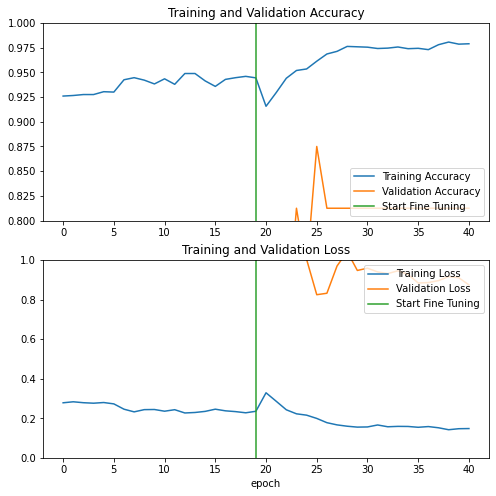

In [89]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [90]:
model.save('/')

INFO:tensorflow:Assets written to: /assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
